# Resnet model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip /content/140k-real-and-fake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3108768711702128244
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7143456814085651905
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [4]:
train = pd.read_csv("real_vs_fake/train.csv")
valid = pd.read_csv("real_vs_fake/valid.csv")
test  = pd.read_csv("real_vs_fake/test.csv")

Reducing the data

In [5]:
def random_n_images(df,no_imgs=10000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1])
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=69).reset_index(drop=True)
    return final_subset

train_subset = random_n_images(train,no_imgs=10000,shuffle=True)
valid_subset = random_n_images(valid,no_imgs=2000,shuffle=False)
test_subset = random_n_images(test,no_imgs=2000,shuffle=False)

Converting to tensors

In [6]:
BATCH_SIZE = 32
image_height = 256
image_width = 256

In [7]:
train_tfds = tf.data.Dataset.from_tensor_slices((train_subset['path'].values,train_subset['label'].values))
valid_tfds = tf.data.Dataset.from_tensor_slices((valid_subset['path'].values,valid_subset['label'].values))
test_tfds = tf.data.Dataset.from_tensor_slices((test_subset['path'].values,test_subset['label'].values))

def read_image(image_file, label):
    image = tf.io.read_file("real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augument(image, label):
    return image, label

train_tfds = train_tfds.map(read_image).map(augument).batch(BATCH_SIZE)
valid_tfds = valid_tfds.map(read_image).map(augument).batch(1).prefetch(1)
test_tfds = test_tfds.map(read_image).map(augument).batch(1)

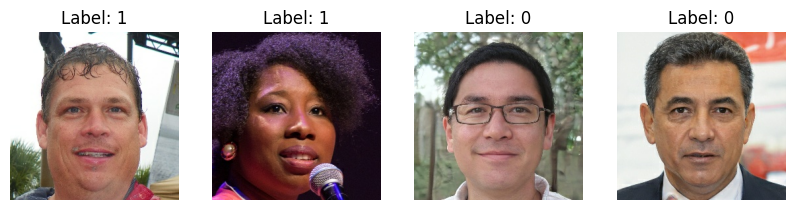

In [8]:
for images, labels in train_tfds.take(1):  # Take the first batch for display
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 4)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

## Convolutional neural network

In [9]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

resnet_clf = Model(inputs=base_model.input, outputs=predictions)

In [11]:
save_callback = ModelCheckpoint('models/resnet_clf_cp.h5'
                                ,save_weights_only=False
                                ,monitor='val_loss'
                                ,save_best_only=True)
# early_stopping_callback = EarlyStopping(monitor='val_loss' ,patience=5)

resnet_clf.compile(optimizer=Adam()
                   ,loss='binary_crossentropy'
                   ,metrics=['accuracy'])
resnet_clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [12]:
tf.keras.backend.clear_session()
resnet_clf_history = resnet_clf.fit(
    train_tfds,
    epochs=10,
    validation_data=valid_tfds,
    callbacks=[save_callback],
    use_multiprocessing=True
)

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.7869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 208s 504ms/step - loss: 0.4633 - accuracy: 0.7869 - val_loss: 1.4330 - val_accuracy: 0.5000
Epoch 2/10
313/313 [==============================] - 176s 563ms/step - loss: 0.2323 - accuracy: 0.9021 - val_loss: 0.8921 - val_accuracy: 0.5250
Epoch 3/10
313/313 [==============================] - 169s 540ms/step - loss: 0.1574 - accuracy: 0.9389 - val_loss: 1.6826 - val_accuracy: 0.5200
Epoch 4/10
313/313 [==============================] - 150s 480ms/step - loss: 0.1071 - accuracy: 0.9600 - val_loss: 1.0303 - val_accuracy: 0.7180
Epoch 5/10
313/313 [==============================] - 158s 506ms/step - loss: 0.0877 - accuracy: 0.9681 - val_loss: 0.4810 - val_accuracy: 0.7975
Epoch 6/10
313/313 [==============================] - 151s 483ms/step - loss: 0.0634 - accuracy: 0.9773 - val_loss: 1.0737 - val_accuracy: 0.7660
Epoch 7/10
313/313 [==============================] - 158s 505ms/step - loss: 0.0549 - accuracy: 0.9802 - val_loss: 0.3636 - val_accura

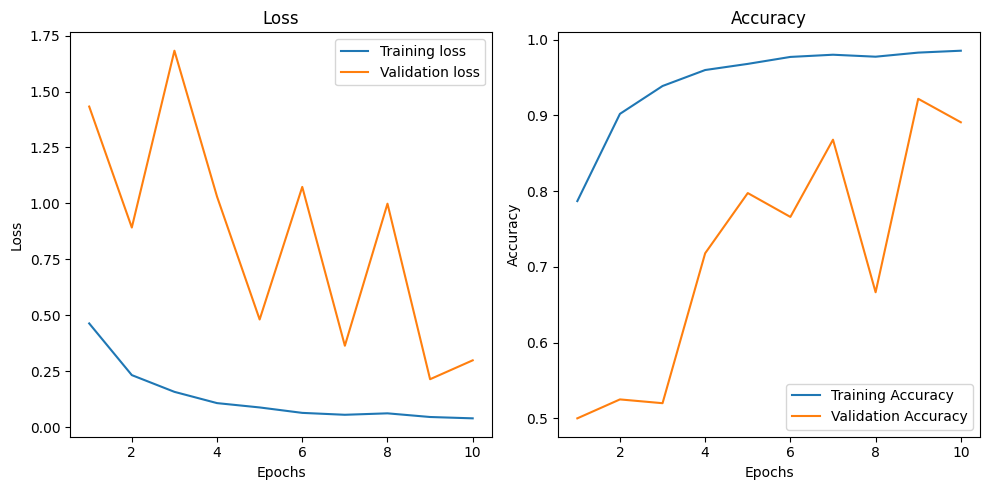

In [13]:
# Visualizing results
training_loss = resnet_clf_history.history['loss']
validation_loss = resnet_clf_history.history['val_loss']
training_accuracy = resnet_clf_history.history['accuracy']
validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

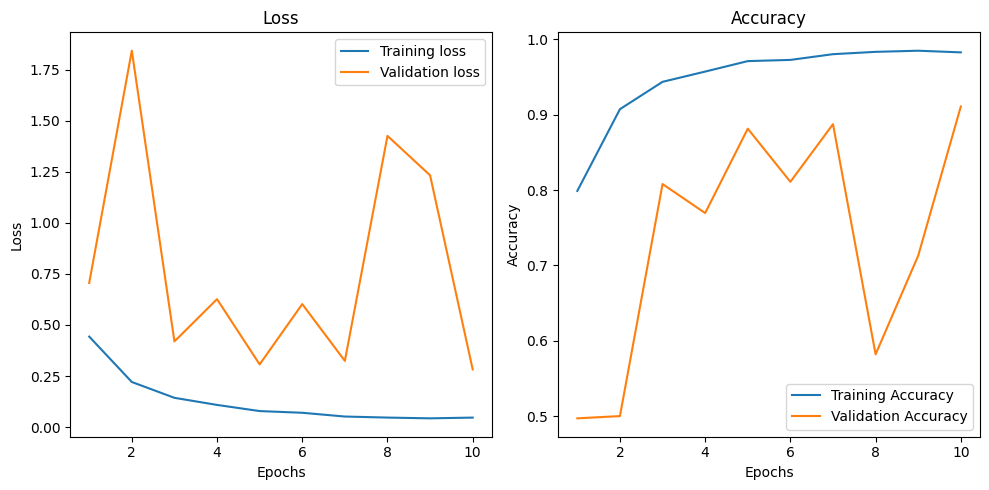

In [ ]:
# Visualizing results
training_loss = resnet_clf_history.history['loss']
validation_loss = resnet_clf_history.history['val_loss']
training_accuracy = resnet_clf_history.history['accuracy']
validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from keras.models import load_model
best_model = load_model("models/resnet_clf_cp_today.h5")

In [16]:
# Testing set
test_loss, test_accuracy = best_model.evaluate(test_tfds, verbose=0)
print(f"Test loss:{test_loss}")
print(f"Test accuracy:{test_accuracy}")

Test loss:0.21396316587924957
Test accuracy:0.9154999852180481


Manual testing

In [36]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [39]:
def manual_prediction(img_path, model):
  img = image.load_img(img_path, target_size=(image_height, image_width))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Normalize pixel values to be between 0 and 1
  img_array /= 255.0

  # Make predictions
  prediction = model.predict(preprocess_input(img_array))

  plt.imshow(img)
  plt.title(f"Label:{prediction[0][0]}")

1/1 [==============================] - 0s 44ms/step


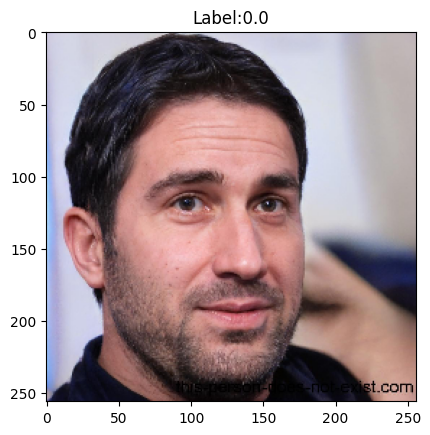

In [40]:
manual_prediction("manual_test_images/Hard.jpeg",best_model)

1/1 [==============================] - 0s 132ms/step


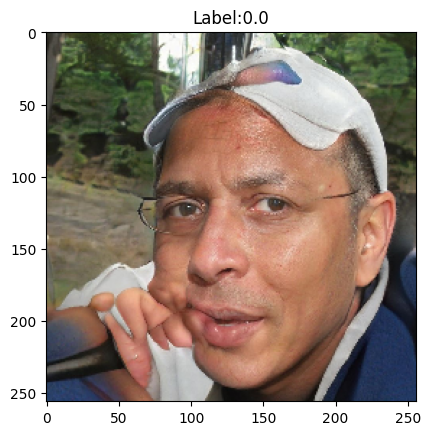

In [42]:
manual_prediction("manual_test_images/Medium.jpg",best_model)

1/1 [==============================] - 0s 106ms/step


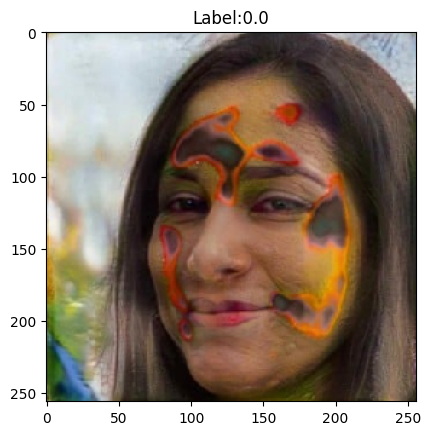

In [43]:
manual_prediction("manual_test_images/Easy.jpg",best_model)

1/1 [==============================] - 0s 24ms/step


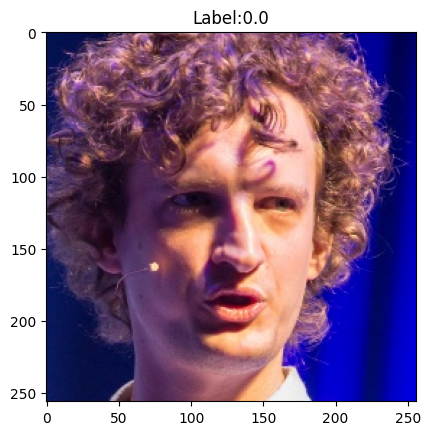

In [47]:
manual_prediction("manual_test_images/Real.jpg",best_model)